## Apparently, when creating these .mat files, Matlab 7.3+ was used, so they cannot be opened in the usual way through Scipy.io.

In [2]:
!pip install h5py

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ----------------- ---------------------- 1.3/3.0 MB 7.4 MB/s eta 0:00:01
   -------------------------------------- - 2.9/3.0 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 7.0 MB/s eta 0:00:00


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage import convolve, binary_closing, binary_fill_holes
with h5py.File('suture/Suture_8400.mat', 'r') as file:
    #lets firstly get all objectts
    print("Keys in the file:", list(file.keys()))

Keys in the file: ['Fs', 'InputRange', 'Lx', 'Ly', 'RepRate', 'S', 'ShiftCorrFlag', 'Z', 'dx', 'dy', 'positionXY', 'trigDelay', 'vAct', 'xLim', 'yLim']


C:\Users\stepo\AppData\Local\Temp\ipykernel_5300\4079207007.py:5: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure


# Since I have not opened these files in Matlab at all, I would first like to understand their structure. The next 2 cells will be dedicated to exactly this

In [49]:
# Open the HDF5 file containing suture data in read-only mode
with h5py.File('suture/Suture_8400.mat', 'r') as f:
    # Iterate through all datasets in the file
    for key in f.keys():
        data = f[key]
        
        # Display the name, shape, and data type of each dataset
        print(f"Dataset: {key}, shape: {data.shape}, dtype: {data.dtype}")
        
        # For 1D datasets or smaller datasets with less than 20 elements, print all values
        if data.ndim == 1 or data.size < 20: 
            print(f"Values: {data[:]}")
        else:
            # Otherwise, print only the first five values for a quick overview
            print(f"First few values: {data[:5]}")


Dataset: Fs, shape: (1, 1), dtype: float64
Values: [[1.e+09]]
Dataset: InputRange, shape: (1, 1), dtype: float64
Values: [[2000.]]
Dataset: Lx, shape: (1, 1), dtype: float64
Values: [[1.5]]
Dataset: Ly, shape: (1, 1), dtype: float64
Values: [[1.5]]
Dataset: RepRate, shape: (1, 1), dtype: float64
Values: [[500.]]
Dataset: S, shape: (2016, 22801), dtype: int16
First few values: [[-60 -45 -60 ... -52 -52 -60]
 [-67 -54 -66 ... -52 -51 -43]
 [-59 -54 -43 ... -59 -50 -49]
 [-61 -56 -56 ... -58 -52 -57]
 [-59 -50 -57 ... -58 -58 -58]]
Dataset: ShiftCorrFlag, shape: (1, 1), dtype: float64
Values: [[1.]]
Dataset: Z, shape: (1, 1), dtype: float64
Values: [[0.]]
Dataset: dx, shape: (1, 1), dtype: float64
Values: [[0.01]]
Dataset: dy, shape: (1, 1), dtype: float64
Values: [[0.01]]
Dataset: positionXY, shape: (2, 22801), dtype: float64
First few values: [[0.000e+00 1.000e-02 2.000e-02 ... 1.480e+00 1.490e+00 1.500e+00]
 [1.326e+01 1.326e+01 1.326e+01 ... 1.476e+01 1.476e+01 1.476e+01]]
Dataset: tr

In [50]:
# Displaying the path to the file being accessed
print(f'path - suture/Reconstruction/Reconstructed.mat')

# Opening the .mat file in read-only mode
with h5py.File('suture/Reconstruction/Reconstructed.mat', 'r') as mat_file:
    
    # Defining a helper function to print the structure of the file content
    # 'name' is the name of each element, and 'obj' is the h5py object (Group or Dataset)
    def print_structure(name, obj):
        # Checking if the object is a group; if so, printing its name
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        # Checking if the object is a dataset; if so, printing its name, shape, and data type
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
    
    # Applying the print_structure function to each element within the .mat file
    mat_file.visititems(print_structure)


path - suture/Reconstruction/Reconstructed.mat
Group: #refs#
Dataset: #refs#/a, shape: (2,), dtype: uint64
Dataset: R, shape: (124, 124, 980), dtype: float32
Group: aP
Dataset: aP/N_t, shape: (1, 1), dtype: float64
Dataset: aP/N_xs, shape: (1, 1), dtype: float64
Dataset: aP/N_ys, shape: (1, 1), dtype: float64
Dataset: aP/PRR, shape: (1, 1), dtype: float64
Dataset: aP/dt, shape: (1, 1), dtype: float64
Dataset: aP/dx, shape: (1, 1), dtype: float64
Dataset: aP/dy, shape: (1, 1), dtype: float64
Dataset: aP/f_s, shape: (1, 1), dtype: float64
Dataset: aP/inputRange, shape: (1, 1), dtype: float64
Dataset: aP/l_x, shape: (1, 1), dtype: float64
Dataset: aP/l_y, shape: (1, 1), dtype: float64
Dataset: aP/triggerDelay, shape: (1, 1), dtype: float64
Dataset: aP/v_x, shape: (1, 1), dtype: float64
Dataset: aP/v_y, shape: (1, 1), dtype: float64
Dataset: aP/x_0, shape: (1, 1), dtype: float64
Dataset: aP/x_lim, shape: (2, 1), dtype: float64
Dataset: aP/y_0, shape: (1, 1), dtype: float64
Dataset: aP/y_li

# Well, this means that 1st file contains meta (parameters of the measurement) and the exact data is stored in dataset *S*

- **Fs** (1e9) is the data sampling frequency equal to 1 GHz (paste here your joke about Cholmogorov's theorem)
- **InputRange** (2000 mV) - input signal range in millivolts
- **Lx, Ly** (1.5 mm)- dimensions of the study area
- **RepRate** (500 Hz)- pulse repetition frequency
- **ShiftCorrFlag** (boolean = 1) - the offset correction flag most likely indicates the inclusion of some kind of data processing
- **dx, dy** (0.01 mm) - the grid pitch with which scanning was carried out along the X and Y axes
- **TrigDelay** (2080 mks) - 
trigger hardware delay, in microseconds most likely, because the detector is based on some kind of microcontroller and there by default microseconds. Correct me if I don't understan
- **<u>S</u>** - the main dataset which I gonna analyze

## BUT! As we see, in **Reconstructed.mat** file the data is given in already reconstructed way. We are interested to reconstruct it by ourselve, simply for methodological and educational reasond

## To open an already reconstructed file, I made the code Orig_reconstruction.py
run it through the console, specifying the path to the already reconstructed file and enjoy

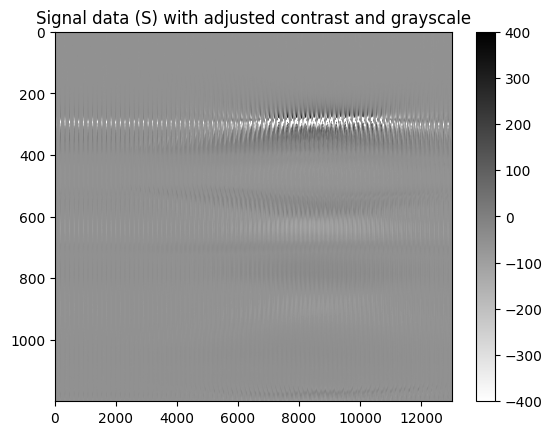

In [52]:
with h5py.File('suture/Suture_8400.mat', 'r') as f:
    '''Firstly lets just look how is the data'''
    S = f['S'][:]
    #Here I'm taking a partial slice along S, just to zoom out the graph and get a better look at the signal.
    S_part = S[800:2000, 7000:20000]
    plt.imshow(S_part, aspect='auto', cmap='gray_r', vmin=-400, vmax=400)  
    plt.title('Signal data (S) with adjusted contrast and grayscale')
    plt.colorbar()
    plt.show()

## To reconstruct an image from a signal, you need to know how the measuring device works. They sent me an illustration that shows how the scan moves across the area

<img src="illustration.png" alt="Illustration example" width="700"/>

What this means in terms of a 3D array S: We have 2016 snake scans, these represent layers along the vertical axis in the laboratory frame of reference. Let's take one of them somewhere in the middle and try to make a reverse pass along the plane, laying out a zig-zag into a normal image
I will try to translate everything into terms of the laboratory reference system, because I am uncomfortable using the terms of ABC planes
(Special thanks to chatgpt for her excellent code commentary skills)

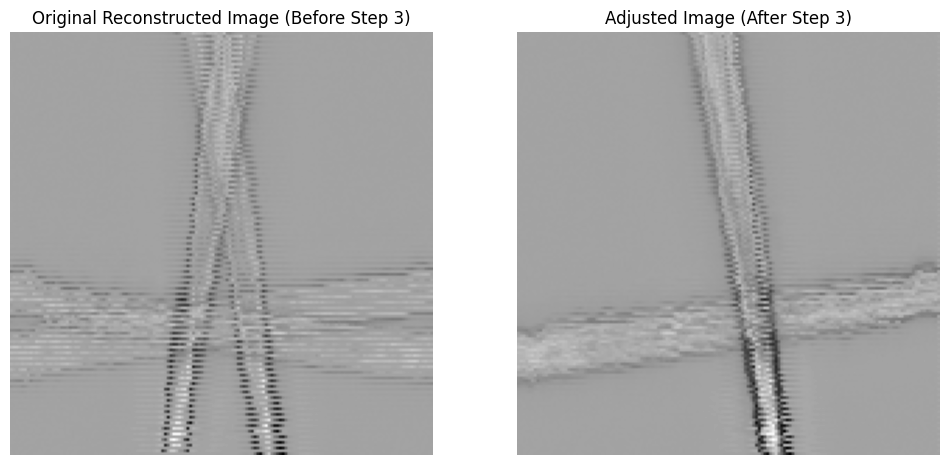

In [59]:
# Extracting the middle layer from the dataset for analysis and visualization
middle_layer = S[1108, :]

# Define the target size of the 2D reconstructed image
image_size = 151

# Step 1: Convert the 1D array into a 2D image using a "zigzag" pattern
def reconstruct_image_zigzag(data, size):
    """
    Reconstructs a 2D image from a 1D array using a zigzag pattern.
    Odd-numbered rows are reversed to match the original zigzag structure.
    
    Parameters:
    data (np.ndarray): 1D array of pixel values
    size (int): Dimension of the square 2D image (size x size)
    
    Returns:
    np.ndarray: 2D array representing the reconstructed image
    """
    image = np.zeros((size, size), dtype=data.dtype)
    for i in range(size):
        if i % 2 == 0:
            # Even rows are assigned directly
            image[i, :] = data[i * size:(i + 1) * size]
        else:
            # Odd rows are reversed to maintain zigzag structure
            image[i, :] = data[i * size:(i + 1) * size][::-1]
    return image

# Step 2: Apply the reconstruction function to convert the middle layer into a 2D image
reconstructed_image = reconstruct_image_zigzag(middle_layer, image_size)
reconstructed_image2 = reconstructed_image.copy()

# Step 3: Flip and shift odd rows to the left by one pixel for adjusted visualization
shift_value = 1  # Number of pixels to shift each row to the left
for i in range(1, image_size, 2):  # Only process odd rows
    flipped_row = np.fliplr([reconstructed_image[i, :]])[0]  # Flip the row horizontally
    shifted_row = np.roll(flipped_row, -shift_value)  # Shift left by shift_value pixels
    shifted_row[-shift_value:] = 0  # Set the last shifted pixels to zero for clarity
    reconstructed_image2[i, :] = shifted_row

# Step 4: Visualize the original and adjusted 2D images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax1.imshow(reconstructed_image, cmap='gray')
ax1.set_title('Original Reconstructed Image (Before Step 3)')
ax1.axis('off')
# Display the adjusted image
ax2.imshow(reconstructed_image2, cmap='gray')
ax2.set_title('Adjusted Image (After Step 3)')
ax2.axis('off')

plt.show()


**<u>Please note</u>**: if you just walk through the array and put the scan lines in their places, we will get 2 copies of the object at once, which occupy alternating rows. In order to put them back in place, you need to take one more step: expand the odd rows in reverse, and move them a little. The shift is needed to make the border of the object less sawtooth. This is caused by uneven scanning speeds in different directions. Select the number of **<u>shift_value</u>** pixels depending on your task

Note that despite the application of the shift of the expanded lines, the border of the object still looks a little sawtooth. In order not to suffer with this, let's just apply a Gaussian filter, which eliminates sharp illogical transitions between pixels

The Gaussian filter is widely used in image processing for smoothing and noise reduction. It works by applying a Gaussian function to each pixel in the image, weighting surrounding pixels based on their distance from the center. This results in a blur that softens edges and reduces high-frequency noise.

The Gaussian function is defined as:
$G(x, y) = \frac{1}{{2 \pi \sigma^2}} \exp\left(-\frac{{x^2 + y^2}}{{2 \sigma^2}}\right)$

𝑥
 and 
𝑦
 represent pixel distances from the center of the filter,
𝜎
(standard deviation) controls the spread (or "width") of the Gaussian blur. A higher 
𝜎 value results in a more blurred image.
In practice, we create a small Gaussian matrix (or kernel) and apply it to each pixel in the image. By doing so, we replace the value of each pixel with a weighted average of its neighbors, where closer pixels contribute more to the average than those further away

The convolution is defined as 

$(f * g)(x, y) = \sum_{i=-k}^k \sum_{j=-k}^k f(x-i, y-j) \cdot g(i, j) 
$.

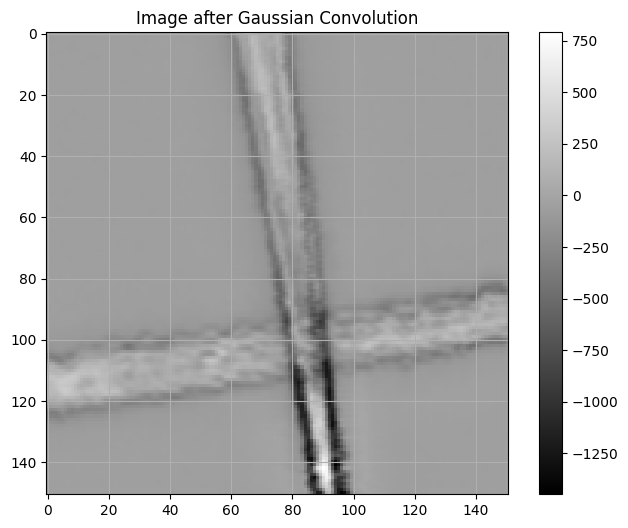

In [63]:
def gaussian_kernel(size, sigma=1):
    """
    Generates a Gaussian kernel (filter) of specified size and standard deviation (sigma).
    
    Parameters:
    size (int): Dimension of the square kernel (size x size).
    sigma (float): Standard deviation for the Gaussian distribution.
    
    Returns:
    np.ndarray: Normalized 2D Gaussian kernel.
    """
    # Create a 1D range centered around zero
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    # Create a 2D grid based on the 1D range
    xx, yy = np.meshgrid(ax, ax)
    # Compute the Gaussian function on the 2D grid
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)  # Normalize the kernel to ensure sum is 1

# Step 3: Generate a 3x3 Gaussian filter with a standard deviation of σ = 1
gaussian_filter = gaussian_kernel(size=3, sigma=1)

# Step 4: Apply the Gaussian filter to the adjusted image using convolution
convoluted_image = scipy.ndimage.convolve(reconstructed_image2, gaussian_filter)

# Display the resulting image after Gaussian convolution
plt.figure(figsize=(8, 6))
plt.imshow(convoluted_image, cmap='gray')
plt.grid(True)
plt.colorbar()
plt.title('Image after Gaussian Convolution')
plt.show()


**Well, it would be possible to stop there, but I want to make not just a set of pictures that can then be viewed with a slider, but also a full-fledged 3D model in voxels. There's no particular practical value here, it's just fun. To do this, we will first have to separate the object from the background**

### Steps for Creating a Voxel Model from Images

Creating a voxel model from an image involves several essential preprocessing steps to ensure that the resulting 3D representation is accurate and meaningful. Each step serves a specific purpose:

1. **Histogram Equalization**:
   - **Purpose**: This step enhances the contrast of the image by redistributing the intensity values. It makes the features in the image more distinguishable, especially in regions with poor lighting or low contrast. By equalizing the histogram, we can ensure that the voxel model captures important details.

2. **Sobel Filter**:
   - **Purpose**: The Sobel filter is used for edge detection. It highlights areas of high spatial frequency, which correspond to edges in the image. By applying the Sobel filter, we can identify the boundaries of objects more clearly, which is crucial for defining the structure of the voxel model.

3. **Binarization**:
   - **Purpose**: Binarization converts the image into a binary format, where pixels are classified as either foreground or background. This simplification is vital for distinguishing the main features of interest from irrelevant details. The binary image serves as the foundation for the subsequent morphological operations.

4. **Morphological Closing**:
   - **Purpose**: Morphological closing helps to fill small holes and gaps in the binary image. This step ensures that the objects are solid and complete, which is important for accurately representing the shape in the voxel model. Closing helps to eliminate noise and enhances the connectivity of the features.

5. **Filling Holes**:
   - **Purpose**: This step further ensures that any remaining voids within the objects are filled. Filling holes contributes to a more solid and realistic representation of the 3D model. It is essential for achieving a faithful reconstruction of the original object, allowing for better analysis and visualization.

By following these steps,n array of we can transform a 2D image into a coherent and detailed voxel model, facilitating further analysis and applications in various fields such as medical imaging, computer graphics, and engineering.


## Theoretically, it would be possible to try to make a model immediately from the images obtained after Gaussian filtering. But here comes another problem: the performance of my hardware will limit the speed of execution of such a task, and besides, Python is not optimized for such a task in the best way. In a good way, this would be considered not on the CPU but on the video card, but for this you will need to connect CuDa. We are not chasing super image quality right now, so I'd rather make the model binary. When in the mood, then I'll somehow rewrite it under CuDa or pure pluses

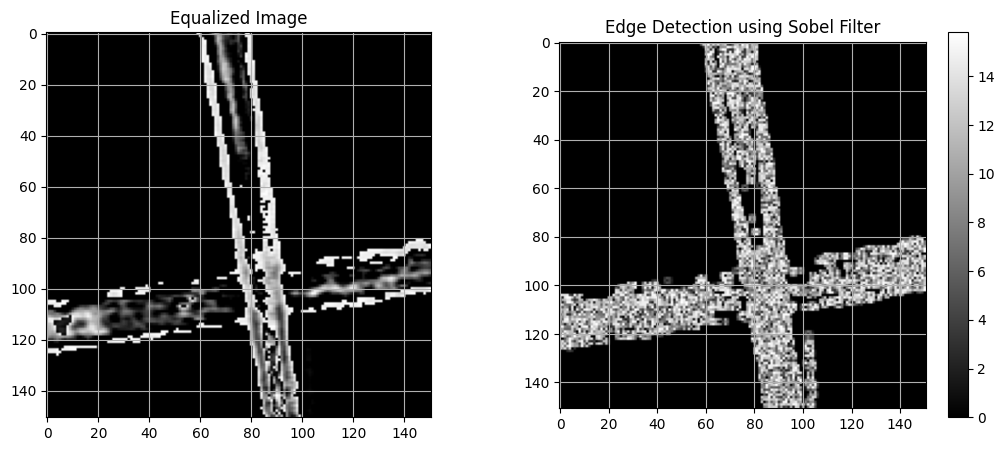

In [71]:
def custom_equalize_histogram(image, low_range=(-1500, -250), high_range=(250, 750)):
    """
    Function for separate histogram equalization for two ranges: low and high values.
    In our case, informative parts of the image may have high > 0 values, but may also be significantly < 0.
    We need to bring them into a unified system.
    """
    # Copy the image to avoid modifying the original
    eq_image = np.copy(image)
    
    # 1. Handle low values
    low_mask = (image >= low_range[0]) & (image <= low_range[1])
    low_values = image[low_mask]
    
    if len(low_values) > 0:
        low_values_normalized = (low_values - low_range[0]) / (low_range[1] - low_range[0])
        low_values_equalized = np.clip(low_values_normalized * 255, 0, 255)
        eq_image[low_mask] = low_values_equalized
    
    # 2. Handle high values
    high_mask = (image >= high_range[0]) & (image <= high_range[1])
    high_values = image[high_mask]
    
    if len(high_values) > 0:
        high_values_normalized = (high_values - high_range[0]) / (high_range[1] - high_range[0])
        high_values_equalized = np.clip(high_values_normalized * 255, 0, 255)
        eq_image[high_mask] = high_values_equalized
    
    # 3. Normalize the entire image to improve overall contrast
    eq_image = np.clip(eq_image, 0, 255).astype(np.uint8)
    
    return eq_image


equalized_image = custom_equalize_histogram(convoluted_image)

# Sobel operator for edge detection
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

# Apply convolution to calculate gradients
grad_x = scipy.ndimage.convolve(equalized_image, sobel_x)
grad_y = scipy.ndimage.convolve(equalized_image, sobel_y)

# Calculate the gradient magnitude
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Display images side by side
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.imshow(gradient_magnitude, cmap='gray')
plt.colorbar()
plt.title('Edge Detection using Sobel Filter')
plt.grid(True)

plt.show()


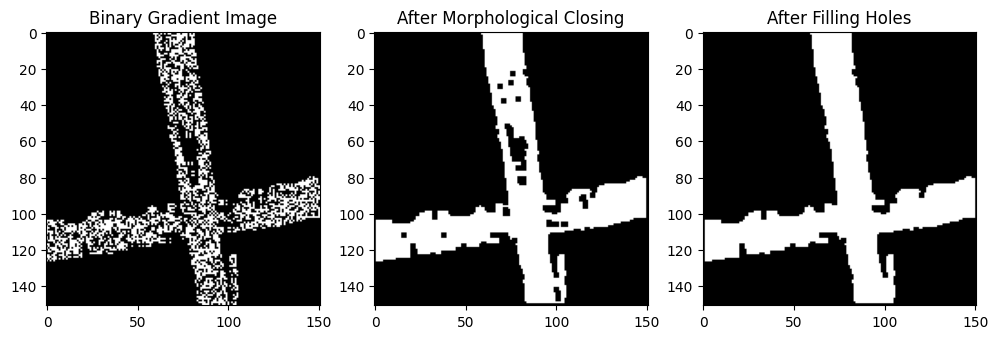

In [75]:
# Binarization of the gradient image
binary_image = gradient_magnitude > 10  # Threshold for binarization (choose an appropriate value)
# Morphological closing to fill small gaps
# Generate a 3x3 structural element
struct_element = generate_binary_structure(2, 2)
closed_image = binary_closing(binary_image, structure=struct_element)
# Fill remaining holes
filled_image = binary_fill_holes(closed_image)
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Gradient Image')
plt.subplot(1, 3, 2)
plt.imshow(closed_image, cmap='gray')
plt.title('After Morphological Closing')
plt.subplot(1, 3, 3)
plt.imshow(filled_image, cmap='gray')
plt.title('After Filling Holes')
plt.show()

## Okay, now that we've practiced on one picture, we can cycle through all the layers of the S array and perform all the transformations without a separate output of each step. I looked through the images of all the layers in advance and realized that our object is in the range 990-1170. I will save these layers in 2 .txt files so that I can open and watch them later, I will throw away the rest so as not to take up memory and not create files larger than 50 megabytes. That is, in this block I just do the same as above, but in a loop

In [76]:
# Image size
image_size = 151

# Initialize arrays to store results
num_layers = S.shape[0]  # Number of layers in the S array
reconstructed_images = np.zeros((num_layers, image_size, image_size), dtype=np.float32)  # For reconstructed images
binary_images = np.zeros((num_layers, image_size, image_size), dtype=bool)  # For binary images

# Function to reconstruct the image with consideration for flipping and shifting odd rows
def reconstruct_image_with_shift(data, size):
    image = np.zeros((size, size), dtype=data.dtype)
    for i in range(size):
        if i % 2 == 0:
            image[i, :] = data[i * size:(i + 1) * size]  # Even rows
        else:
            image[i, :] = data[i * size:(i + 1) * size][::-1]  # Odd rows in reverse order
    
    # Shift odd rows
    shift_value = 1  # Number of pixels to shift left
    for i in range(1, size, 2):  # Only odd rows
        flipped_row = np.fliplr([image[i, :]])[0]  # Flip the row
        shifted_row = np.roll(flipped_row, -shift_value)  # Shift left by shift_value
        shifted_row[-shift_value:] = 0  # Zero out the last pixels that overflowed during the shift
        image[i, :] = shifted_row
        
    return image

# Function to process a single layer
def process_layer(layer_data):
    # Step 1: Transform the one-dimensional array into a two-dimensional one, considering "zigzag" and shift
    reconstructed_image = reconstruct_image_with_shift(layer_data, image_size)
    
    # Step 2: Apply Gaussian filter
    gaussian_filter = gaussian_kernel(size=3, sigma=1)  # Generate Gaussian filter
    convoluted_image = scipy.ndimage.convolve(reconstructed_image, gaussian_filter)

    # Step 3: Binarization
    binary_image = convoluted_image > 10  # Threshold for binarization

    # Step 4: Morphological closing
    struct_element = generate_binary_structure(2, 2)
    closed_image = binary_closing(binary_image, structure=struct_element)

    # Step 5: Fill remaining holes
    filled_image = binary_fill_holes(closed_image)
    
    return convoluted_image, filled_image

# Loop through all layers in S
for i in range(num_layers):
    middle_layer = S[i, :]  # Select the layer
    reconstructed_images[i], binary_images[i] = process_layer(middle_layer)

# Now you have two three-dimensional arrays:
# reconstructed_images - for reconstructed images
# binary_images - for binary images

start_index = 990
end_index = 1170

# Save only layers from 950 to 1200 in a two-dimensional format
np.savetxt('reconstructed_images.txt', reconstructed_images[start_index:end_index].reshape(-1, image_size * image_size), fmt='%.6f')
np.savetxt('binary_images.txt', binary_images[start_index:end_index].reshape(-1, image_size * image_size), fmt='%d')



## All we have to do is open the file via the console My_reconstruction.py , tell him the name of the file that we want to view, and scroll through the layers and watch the pictures.

# STOP HERE

# STOOOOOOP

# DO NOT run this cell if U don't have enough powerful computer. Mine one died 4 times

Shapes:
voxels shape: (25, 151, 151)
x shape: (26, 152, 152)
y shape: (26, 152, 152)
z shape: (26, 152, 152)


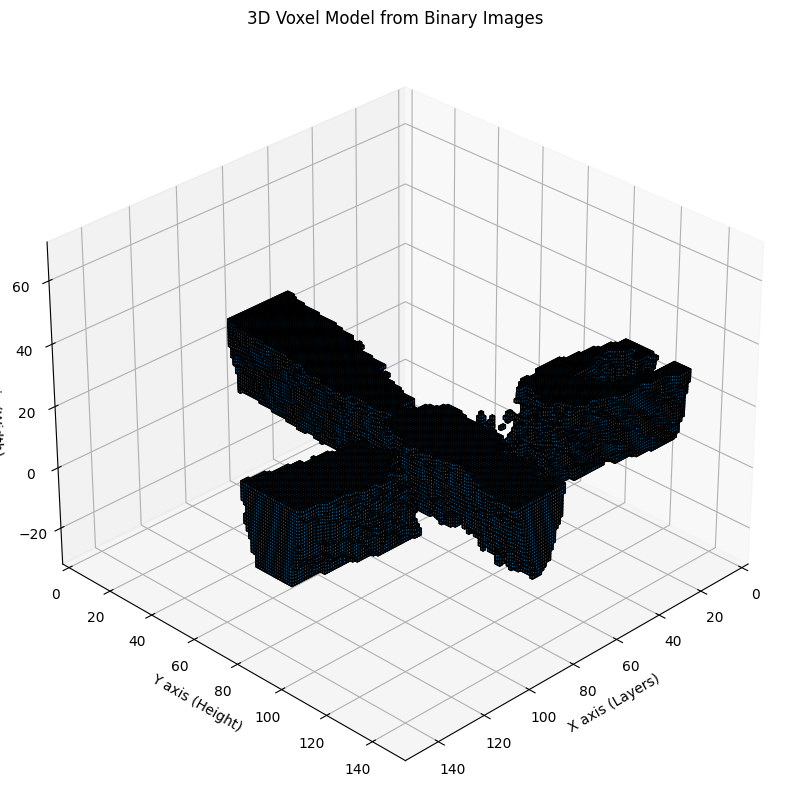

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Example of creating a 3D array of binary images
binary_images = binary_images[start_index:end_index]
num_layers, height, width = binary_images.shape

# Create a 3D voxel array
voxels = np.zeros((num_layers, height, width), dtype=bool)

# Fill the voxel array
for i in range(num_layers):
    voxels[i, :, :] = binary_images[i] > 0  # Ensure that the data is binary

# Visualization of the 3D model
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate arrays
x = np.arange(num_layers + 1)    # (145,)
y = np.arange(height + 1)        # (151,)
z = np.arange(width + 1)         # (151,)

# Generate the coordinate grid
x, y, z = np.meshgrid(x, y, z, indexing='ij')

# Shape verification
print("Shapes:")
print("voxels shape:", voxels.shape)
print("x shape:", x.shape)
print("y shape:", y.shape)
print("z shape:", z.shape)

# Plot the voxel planes
ax.voxels(z, y, x, voxels, edgecolor='k')

# Set axis labels
ax.set_xlabel('X axis (Layers)')
ax.set_ylabel('Y axis (Height)')
ax.set_zlabel('Z axis (Width)')
ax.set_title('3D Voxel Model from Binary Images')

# Positioning for an isometric view

# Set equal scaling for all axes
ax.set_xlim([0, width])  # Set range for Z axis
ax.set_ylim([0, height])  # Set range for Y axis
ax.set_zlim([-30, 70])  # Set range for X axis

ax.view_init(30, 45)
plt.show()


## Okay, that's good. Now let's try to do the SAFT procedure. So far, using Gaussian beams as an approximation. Then we'll think about what other functions we can use.

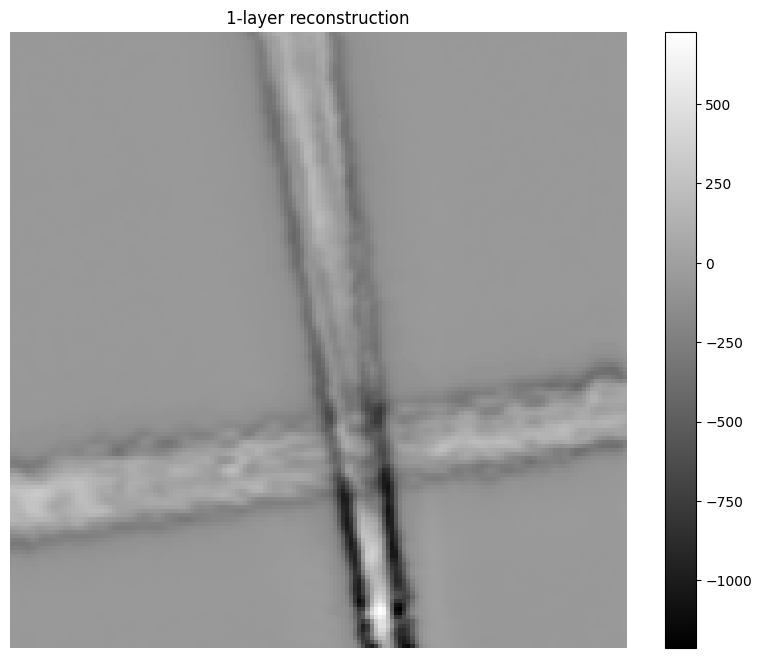

In [92]:
start_index = 990
end_index = 1200
# Задаем размер изображения
image_size = 151

# Инициализируем массивы для хранения результатов
num_layers = S.shape[0]  # Количество слоев в массиве S
reconstructed_images = np.zeros((num_layers, image_size, image_size), dtype=np.float32)  # Для реконструированных изображений
binary_images = np.zeros((num_layers, image_size, image_size), dtype=bool)  # Для бинарных изображений

# Функция для реконструкции изображения с учетом переворота и сдвига нечетных рядов
def reconstruct_image_with_shift(data, size):
    image = np.zeros((size, size), dtype=data.dtype)
    for i in range(size):
        if i % 2 == 0:
            image[i, :] = data[i * size:(i + 1) * size]  # Четные ряды
        else:
            image[i, :] = data[i * size:(i + 1) * size][::-1]  # Нечетные ряды в обратном порядке

    # Сдвиг нечетных рядов
    shift_value = 1  # Количество пикселей для сдвига влево
    for i in range(1, size, 2):  # Только нечетные ряды
        flipped_row = np.fliplr([image[i, :]])[0]  # Перевернуть ряд
        shifted_row = np.roll(flipped_row, -shift_value)  # Сдвинуть влево на shift_value
        shifted_row[-shift_value:] = 0  # Зануляем последние пиксели, которые переполняются во время сдвига
        image[i, :] = shifted_row
        
    return image

# Функция для обработки одного слоя
def process_layer(layer_data):
    # Шаг 1: Преобразование одномерного массива в двумерный, учитывая "зигзаг" и сдвиг
    reconstructed_image = reconstruct_image_with_shift(layer_data, image_size)
    
    # Шаг 2: Применение Гауссовского фильтра
    convoluted_image = gaussian_filter(reconstructed_image, sigma=1)
    return convoluted_image

# Обрабатываем все слои в S
for i in range(num_layers):
    middle_layer = S[i, :]  # Выбираем слой
    reconstructed_images[i] = process_layer(middle_layer)


# Визуализация среднего изображения
plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_images[1109], cmap='gray')
plt.title('1-layer reconstruction')
plt.axis('off')  # Убираем оси для чистоты изображения
plt.colorbar()  # Добавляем цветовую шкалу
plt.show()


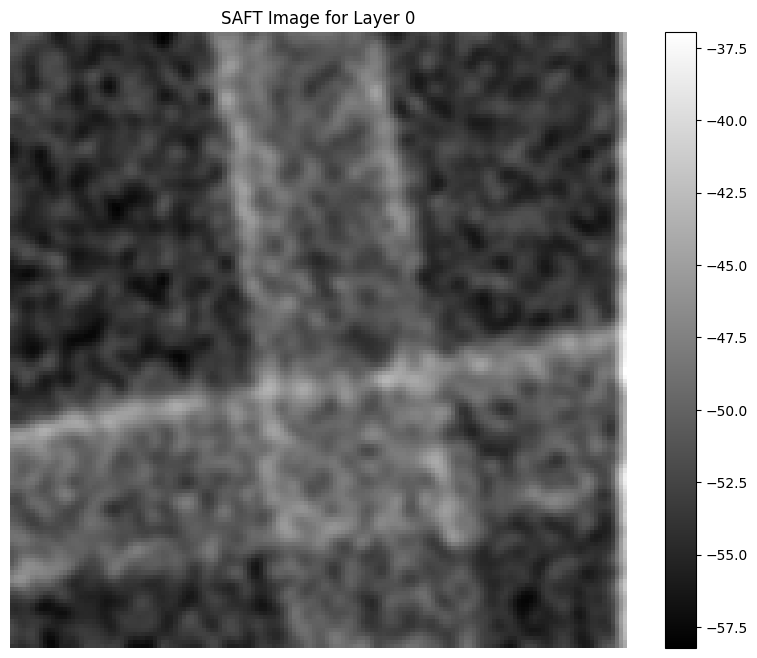

In [94]:
start_index = 990
end_index = 1200
# Set image size
image_size = 151

# Initialize arrays to store results
num_layers = S.shape[0]  # Number of layers in array S
reconstructed_images = np.zeros((num_layers, image_size, image_size), dtype=np.float32)  # For reconstructed images
binary_images = np.zeros((num_layers, image_size, image_size), dtype=bool)  # For binary images

# Function to reconstruct image with flip and shift for odd rows
def reconstruct_image_with_shift(data, size):
    image = np.zeros((size, size), dtype=data.dtype)
    for i in range(size):
        if i % 2 == 0:
            image[i, :] = data[i * size:(i + 1) * size]  # Even rows
        else:
            image[i, :] = data[i * size:(i + 1) * size][::-1]  # Odd rows in reverse order

    # Shift odd rows
    shift_value = 1  # Number of pixels to shift left
    for i in range(1, size, 2):  # Only odd rows
        flipped_row = np.fliplr([image[i, :]])[0]  # Flip row
        shifted_row = np.roll(flipped_row, -shift_value)  # Shift left by shift_value
        shifted_row[-shift_value:] = 0  # Zero out overflowed pixels after shift
        image[i, :] = shifted_row
        
    return image

# Function to process a single layer
def process_layer(layer_data):
    # Step 1: Convert 1D array to 2D, accounting for "zigzag" and shift
    reconstructed_image = reconstruct_image_with_shift(layer_data, image_size)
    
    # Step 2: Apply Gaussian filter
    convoluted_image = gaussian_filter(reconstructed_image, sigma=1)
    return convoluted_image

# Process all layers in S
for i in range(num_layers):
    middle_layer = S[i, :]  # Select layer
    reconstructed_images[i] = process_layer(middle_layer)

# Visualization of a single layer
plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_images[1109], cmap='gray')
plt.title('1-layer reconstruction')
plt.axis('off')  # Remove axes for image clarity
plt.colorbar()  # Add color scale
plt.show()


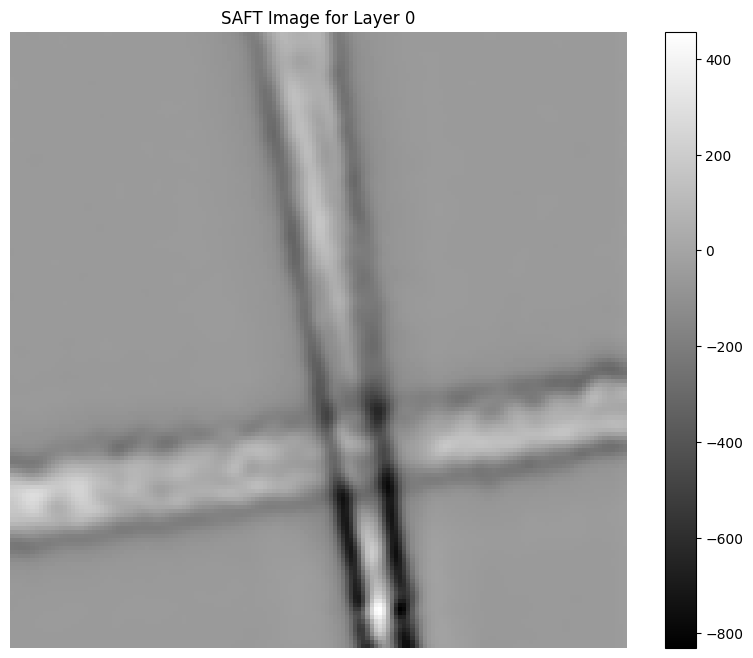

In [98]:
# Визуализация первого слоя SAFT
plt.figure(figsize=(10, 8))
plt.imshow(saft_images[120], cmap='gray')
plt.title('SAFT Image for Layer N')
plt.axis('off')
plt.colorbar()
plt.show()


In [101]:
np.savetxt('safted_gaussian.txt', saft_images.reshape(-1, image_size * image_size), fmt='%.6f')

## If you open it through a slicer (I don't want bills, I feel sorry for the laptop), it will become clear that the result is actually not super different from Dummy reconstruction. It is clear that in the real world it is necessary to do SAFT, I will not argue, but in this particular educational case it is possible to skip it

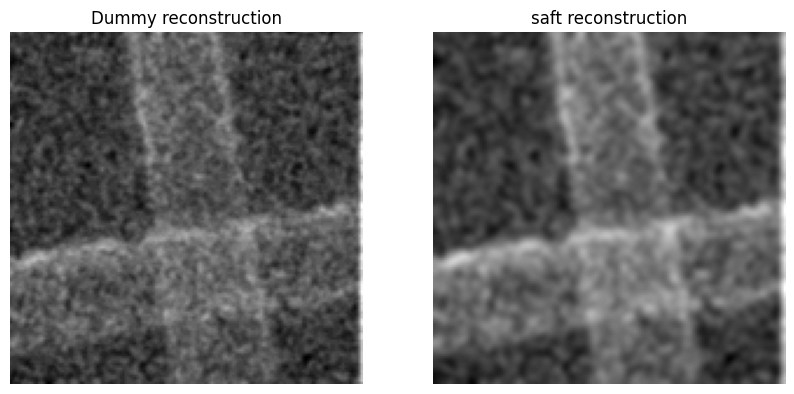

In [109]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(reconstructed_images[3], cmap='gray')
plt.title('Dummy reconstruction')
plt.axis('off')
plt.grid(True)
plt.subplot(1,2,2)
plt.imshow(saft_images[3], cmap='gray')
plt.title('saft reconstruction')
plt.axis('off')
plt.grid(True)

plt.show()